In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

# Predicting building demolition risk in Philadelphia, 2015-2021

## Introduction and Literature Review


## Presentation of Data
### Data collection
#### Property characteristics

In [2]:
#Get data on private demolitions post-2015 from API
demolitions = pd.read_csv("https://phl.carto.com/api/v2/sql?format=CSV&q=SELECT%20address,%20typeofwork%20FROM%20demolitions%20WHERE%20city_demo%20=%20%27NO%27%20AND%20start_date%20>=%20%272018-01-01%27")

In [3]:
demolitions.drop(index=demolitions[demolitions['typeofwork'] == 'TANKRI'].index, inplace=True) #drop tank removals

In [4]:
demolitions.shape

(1333, 2)

In [27]:
#Get selected features of all properties in Philadelphia
chunks = []
dtypes = {
    'lng': 'float64',
    'lat': 'float64',
    'location': 'object',
    'category_code_description': 'category',
    'interior_condition': 'category', #ordinal scale, therefore encoding this feature as a category
    'exterior_condition': 'category',
    'total_area': 'float64',
    'year_built': 'object',
    'parcel_number': 'object',
    'census_tract': 'object'
}

chunked_df = pd.read_csv('https://phl.carto.com/api/v2/sql?format=CSV&q=SELECT%20ST_X(the_geom)%20AS%20lng,%20ST_Y(the_geom)%20AS%20lat,%20location,%20category_code_description,%20interior_condition,%20exterior_condition,%20total_area,%20year_built,%20parcel_number,%20census_tract%20FROM%20opa_properties_public', 
                         dtype=dtypes,
                         chunksize=40000)

for chunk in chunked_df:
    chunk['demolition'] = chunk['location'].isin(demolitions['address']).astype(np.int8) #create binary field encoding whether or not an address is associated with a demolition permit
    chunks.append(chunk)

In [6]:
properties = pd.concat(chunks)

In [7]:
properties.shape

(581456, 11)

In [8]:
properties.sample(5)

,lng,lat,location,category_code_description,interior_condition,exterior_condition,total_area,year_built,parcel_number,census_tract,demolition
235335,-75.264115,39.974033,1372 N 75TH ST,Single Family,4,4,1684.2,1949,343280600,98,0
321896,-75.102475,39.987996,3298 1/2 MILLER ST,Single Family,4,4,992.0,1910,451356200,379,0
141860,-75.208758,40.019228,177 OSBORN ST,Single Family,4,4,1469.7,1950,213048900,209,0
9829,-75.148049,39.934617,1008 E MOYAMENSING AVE,Single Family,4,4,1600.0,1960,021394900,25,0
229361,-75.262306,39.976828,7307 MALVERN AVE,Single Family,4,4,1472.0,1949,344088300,98,0


The most comprehensive property dataset is the most recent one. However, for 86.3% of properties with an associated demolition permit, the property assessment on file is for prior to their demolition, or the building has not yet been demolished. The remaining properties have been re-assessed since their demolition and are now listed as vacant land. Since the model includes building characteristics, and these features are not available for properties classed as 'Vacant Land', demolished properties that have been re-assessed since their demolition were dropped from the dataset. 

In [9]:
properties.groupby(['category_code_description', 'demolition']).size()

category_code_description  demolition
Commercial                 0              13921
                           1                138
Industrial                 0               4275
                           1                 79
Mixed Use                  0              14324
                           1                 72
Multi Family               0              42316
                           1                146
Single Family              0             460990
                           1                583
Vacant Land                0              44450
                           1                162
dtype: int64

In [10]:
properties.drop(index=properties[properties['category_code_description'] == 'Vacant Land'].index, inplace=True)

In [11]:
properties.shape

(536844, 11)

In [12]:
#Load in market value for properties in 2018
value18 = pd.read_csv('https://phl.carto.com/api/v2/sql?format=CSV&q=SELECT%20parcel_number,%20market_value%20FROM%20assessments%20WHERE%20year%20=%202018',
                     dtype={
                         'parcel_number': 'object',
                         'market_value': 'float64'
                     })

In [13]:
properties = pd.merge(properties, value18, how='left', on='parcel_number')

In [14]:
#Drop properties with text or null values in year_built field
properties.drop(index=properties[properties['year_built'].str.contains(r'[A-Za-z]+', na=True)].index, inplace=True)
properties['year_built'] = properties['year_built'].astype('int64')

In [15]:
#Drop properties constructed after 2018
properties.drop(index=properties[properties['year_built'] > 2018].index, inplace=True)

#Add field encoding age of properties in 2018
properties['age'] = 2018 - properties['year_built']

#### Distance attributes

In [16]:
#Drop properties with null lat and long coordinates (they show up in pandas.info() as null, but not in the preview,
#but they still cause bugs in spatial operations)
properties.drop(index=properties['lat'][properties['lat'].isna()].index, inplace=True)

In [17]:
#Convert data frame to georeferenced dataframe to 
geo_properties = gpd.GeoDataFrame(properties,
                                  geometry=gpd.points_from_xy(properties.lng, properties.lat))

In [18]:
geo_properties.set_crs('epsg:4326', inplace=True) #set projection to WGS84
geo_properties.to_crs('epsg:2272', inplace=True) #reproject to NAD 1983 for southern PA
geo_properties.set_index('parcel_number', inplace=True) #set index

In [19]:
del(properties) #save memory

##### Distance to City Hall

In [20]:
#Add field encoding distance from each property to City Hall

#Get Easting and Northing coordinates for City Hall
city_hall = gpd.GeoSeries(Point(-75.1635112, 39.952335), crs=4326)
city_hall.to_crs('epsg:2272') #reproject to NAD 1983

0    POINT (2693536.305 236112.283)
dtype: geometry

In [21]:
#Turn City Hall into point object
city_hall = Point(2693536.305, 236112.283)

#Add field with distance to City Hall
geo_properties['dist_city_hall'] = geo_properties.distance(city_hall)

#Convert from feet to miles
geo_properties['dist_city_hall'] = geo_properties['dist_city_hall'] * 0.000189394

##### Distance to nearest public transportation stop

In [22]:
#Import public transportation shapefiles

##Trolley stops (within Philadelphia county)
trolley = gpd.read_file('https://services2.arcgis.com/9U43PSoL47wawX5S/arcgis/rest/services/Trolley_Stops1/FeatureServer/0/query?where=1%3D1&outFields=Route&outSR=4326&f=json')

##MFL stops
MFL = gpd.read_file('https://services2.arcgis.com/9U43PSoL47wawX5S/arcgis/rest/services/Market_Frankford_Line_Stations/FeatureServer/0/query?where=1%3D1&outFields=Route&outSR=4326&f=json')

##BSL stops
BSL = gpd.read_file('https://services2.arcgis.com/9U43PSoL47wawX5S/arcgis/rest/services/Broad_Street_Line_Stations/FeatureServer/0/query?where=1%3D1&outFields=Route&outSR=4326&f=json')

##Regional Rail stops (within Philadelphia County)
RR = gpd.read_file('https://services2.arcgis.com/9U43PSoL47wawX5S/arcgis/rest/services/Regional_Rail_Stations/FeatureServer/0/query?where=1%3D1&outFields=Line_Name,County&outSR=4326&f=json')

In [23]:
#Drop Regional Rail stations that aren't in Philadelphia
RR.drop(index=RR[RR['County'] != 'Philadelphia'].index, inplace=True)
RR.drop(columns='County', inplace=True)
RR.rename(columns={'Line_Name': 'Route'}, inplace=True)

In [24]:
##Concatenate transportation stops into one gdf of all transportation stops
transport = pd.concat([trolley, MFL, BSL, RR])
transport.to_crs('epsg:2272', inplace=True)

In [25]:
#Finding distance of each property to closest transport stop using scipy spatial cKDTree (fastest method)
def nearest_transport(props, transport):   
    '''Constructs cKDTree of transport stops, then returns Series of distances to closest transport stop
    for each property'''
    
    #Convert geometry columns to arrays
    prop_array = np.array(list(zip(props.geometry.x, props.geometry.y)))
    transport_array = np.array(list(zip(transport.geometry.x, transport.geometry.y)))
    
    #Construct cKDTree of transportation stops
    tree = cKDTree(transport_array)
    
    #Query tree to find distance to closest transport stop
    dist, idx = tree.query(prop_array,k=1) #dist is array of distances to closest point, idx is array of indices of closest points (not needed)
    
    #Since Easting and Northing are in feet, distances have to be converted to miles
    f = lambda x: x * 0.000189394
    dist_miles = f(dist) 
    
    return pd.Series(dist_miles, name='dist_to_transport', index=props.index)

In [26]:
geo_properties['dist_to_transport'] = nearest_transport(geo_properties, transport)

#### Neighbourhood attributes (change from 2000 to 2018)

In [37]:
#Function to extract Philadelphia from LTDB data
def get_phl_data(fname):
    full_df = pd.read_csv(fname)
    
    df = full_df.loc[
        full_df['county'] == 'Philadelphia County'
    ].copy()
    
    del(full_df)
    return df

In [38]:
census00 = get_phl_data('data/LTDB_Std_2000_fullcount/LTDB_Std_2000_fullcount.csv')
census00_sample = get_phl_data('data/LTDB_Std_2000_Sample.csv')

In [ ]:
#Find percentage of population for relevant variables
pop_cols = ['NHWT00', 'NHBLK00', 'HISP00', 'COL00'] #divie by POP00
hu_cols = ['OWN00', 'RENT00'] #divide by HU00
ag25_col = 'COL00' #divide by age 25 up column - doesn't seem to be here?


In [43]:
census00.columns

Index(['TRTID10', 'state', 'county', 'tract', 'placefp10', 'cbsa10',
       'metdiv10', 'ccflag10', 'POP00', 'NHWHT00', 'NHBLK00', 'NTV00',
       'ASIAN00', 'HISP00', 'HAW00', 'INDIA00', 'CHINA00', 'FILIP00',
       'JAPAN00', 'KOREA00', 'VIET00', 'MEX00', 'PR00', 'CUBAN00', 'HU00',
       'VAC00', 'OHU00', 'A18UND00', 'A60UP00', 'A75UP00', 'AGEWHT00',
       'A15WHT00', 'A60WHT00', 'AGEBLK00', 'A15BLK00', 'A60BLK00', 'AGEHSP00',
       'A15HSP00', 'A60HSP00', 'AGENTV00', 'A15NTV00', 'A60NTV00', 'AGEASN00',
       'A15ASN00', 'A60ASN00', 'FAMILY00', 'FHH00', 'OWN00', 'RENT00',
       'GlobD00', 'GlobG00'],
      dtype='object')

In [44]:
census00_sample.columns

Index(['TRTID10', 'state', 'county', 'tract', 'placefp10', 'cbsa10',
       'metdiv10', 'ccflag10', 'POP00SF3', 'RUANC00', 'ITANC00', 'GEANC00',
       'IRANC00', 'SCANC00', 'RUFB00', 'ITFB00', 'GEFB00', 'IRFB00', 'SCFB00',
       'FB00', 'NAT00', 'N10IMM00', 'AG5UP00', 'OLANG00', 'LEP00', 'AG25UP00',
       'HS00', 'COL00', 'AG15UP00', 'Mar-00', 'WDS00', 'CLF00', 'UNEMP00',
       'DFLABF00', 'FLABF00', 'EMPCLF00', 'PROF00', 'MANUF00', 'SEMP00',
       'AG18CV00', 'VET00', 'CNI16U00', 'DIS00', 'DPOV00', 'NPOV00',
       'N65POV00', 'DFMPOV00', 'NFMPOV00', 'DWPOV00', 'NWPOV00', 'DBPOV00',
       'NBPOV00', 'DNAPOV00', 'NNAPOV00', 'DHPOV00', 'NHPOV00', 'DAPOV00',
       'NAPOV00', 'INCPC00', 'HU00SP', 'H30OLD00', 'OHU00SP', 'H10YRS00',
       'DMULTI00', 'MULTI00', 'HINC00', 'HINCW00', 'HINCB00', 'HINCH00',
       'HINCA00', 'MHMVAL00', 'MRENT00', 'HH00', 'HHW00', 'HHB00', 'HHH00',
       'HHA00'],
      dtype='object')

In [ ]:
#Get Census data from API (ACS 5-year estimates from 2013 to 2018)
#neighborhood market value
#college-educated population
#median household income
#white population (+ percent change in white population since 2000)
#black population (+ percent change in black population since 2000)
#hispanic population (+ percent change in hispanic population since 2000)

In [ ]:
#Join Census tract data from 2018 to each property (load Census tract shapefile, then gpd sjoin)


In [ ]:
#Add field encoding percentage change for each variable since 2000

### Data cleaning

In [ ]:
#Check for columns where most values are null, then drop

In [ ]:
#Check rows where most values are null, then drop

In [ ]:
#Convert categorical features into dummies using sklearn DictVectorizer

### Summary statistics

In [ ]:
#Correlation matrix

<AxesSubplot:ylabel='Frequency'>

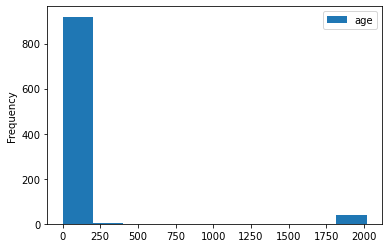

In [40]:
#Histograms of continuous variables

## Methodology

In [4]:
#Write function to tune hyperparameters for each classifier with GridSearchCV

### Random Forest classifier

In [ ]:
#Tune hyperparameters using GridSearchCV

### k-Nearest Neighbours classifier

In [ ]:
#Tune hyperparameters using GridSearchCV

## Results and Discussion

In [3]:
#Metrics for each classifier (table)

In [ ]:
#Confusion matrix for each classifier (figure)

In [ ]:
#Map of false positives for each classifier

In [ ]:
#Map of false negatives for each classifier

## Conclusion

## References